In [1]:
%matplotlib inline

In [2]:
import pandas as pd

# Load the dream5 dataset
Please download the following datasets from the [dream5 dedicated website] (you need to create an account first)(https://www.synapse.org/#!Synapse:syn3130840):


+ `net3_expression_data.tsv`: E. coli gene expression data (MicroArray)
+ `net3_transcription_factors.tsv`: transcription factor genes

### Load the datasets
+ Load the gene expression dataset $X$

In [3]:
X = pd.read_csv("net3_expression_data.tsv",sep="\t").T# rows represent genes and columns represent conditions

+ Load the Transcription Factors list

In [4]:
tf = pd.read_csv("net3_transcription_factors.tsv",header=None)[0]

# Preprocessing

Apply a simple z-score gene-wise (axis=0)

In [5]:
from grenadine.Preprocessing.standard_preprocessing import z_score

In [6]:
X = z_score(X,axis=1)

# Infer the GRN
+ Load the score links function and BayesianRidgeScore method

In [7]:
from grenadine.Inference.inference import score_links
from grenadine.Inference.regression_predictors import BayesianRidgeScore

/Users/sergiopeignier/Documents/libraries/grenadine/grenadine/Inference/inference.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


sklearn.linear_model.RandomizedLasso could not be loaded
RandomizedLasso is not available in sklearn 1.0


+ Choose the parameters of the underlying Bayesian ridge model of the BayesianRidgeScore method 

(the parameters are the same as those of [sklearn BayesianRidge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html#sklearn.linear_model.BayesianRidge))

In [8]:
BayesianRidgeScore_params = {"n_iter":300,
                             "tol":1e-3}

+ Score all the possible edges between Transcription Factors and Target Genes

In [9]:
score_matrix = score_links(gene_expression_matrix=X,
                           score_predictor=BayesianRidgeScore,
                           tf_list=tf,
                           progress_bar=True,
                           **BayesianRidgeScore_params)

# Visualize the results

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(33.0, 0.5, 'TGs')

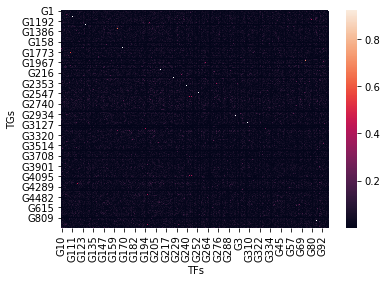

In [11]:
sns.heatmap(score_matrix)
plt.xlabel("TFs")
plt.ylabel("TGs")

Selecting only top scores above a given threshold can provide a GRN

Text(33.0, 0.5, 'TGs')

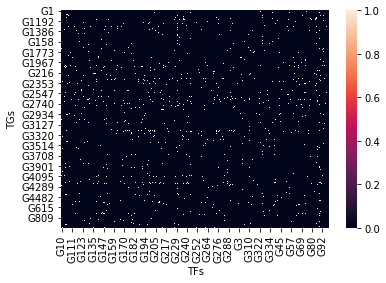

In [12]:
sns.heatmap(score_matrix>=0.1)
plt.xlabel("TFs")
plt.ylabel("TGs")

The distribution of scores can be used to set a threshold

Text(0, 0.5, 'Frequencies')

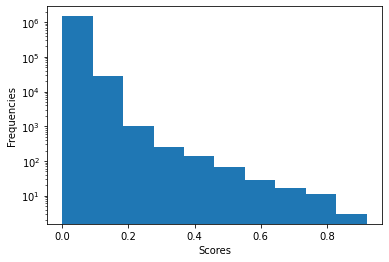

In [13]:
_=plt.hist(score_matrix.values.flatten() ,log=True)
plt.xlabel("Scores")
plt.ylabel("Frequencies")

# Rank the links according to their scores

In [14]:
from grenadine.Inference.inference import rank_GRN
ranking = rank_GRN(score_matrix)

In [15]:
ranking.head(10)

rank     score    TF     TG
G73_G2884    1.0  0.919943   G73  G2884
G187_G2989   2.0  0.858752  G187  G2989
G77_G306     3.0  0.854593   G77   G306
G139_G2155   4.0  0.817564  G139  G2155
G116_G2990   5.0  0.806792  G116  G2990
G187_G1195   6.0  0.801861  G187  G1195
G194_G329    7.0  0.787530  G194   G329
G329_G194    8.0  0.786664  G329   G194
G150_G1090   9.0  0.785604  G150  G1090
G110_G219   10.0  0.784467  G110   G219

# Plot the top 100 edges GRN using networkx

Convert the top 100 edges to a NetworkX DiGraph

In [99]:
from grenadine.Evaluation.evaluation import rank_to_networkx
grn_inferred_top100 = rank_to_networkx(ranking, top_n=100)

Plot the network using NetworkX 

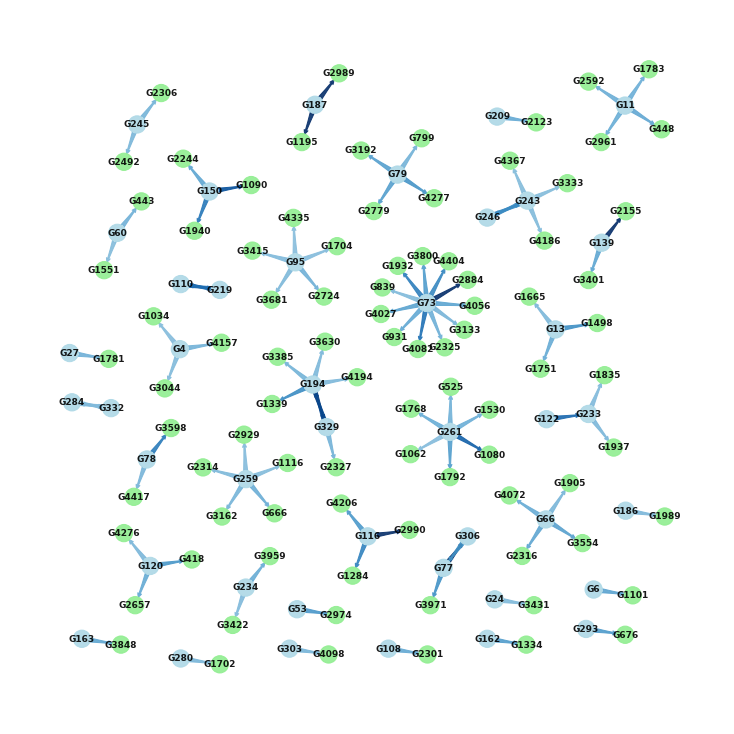

In [101]:
import networkx as nx
import numpy as np
# Define the colors of the nodes
colnodes = []
for node in grn_inferred_top100:
    if node in tf.values:
        colnodes.append('lightBlue')
    else: 
        colnodes.append('lightGreen') 

# Define scores for the edge colors as 1/(log(rank)+1) 
edge_colors = []
for edge in grn_inferred_top100.edges():
    edge_colors.append(1/np.log(grn_inferred_top100[edge[0]][edge[1]]["rank"]+1))

# Define the fire size
plt.figure(figsize=(10,10))

# Plot the network
nx.draw(grn_inferred_top100,edge_cmap=plt.cm.Blues,
        pos = nx.nx_agraph.graphviz_layout(grn_inferred_top100),
        node_color=colnodes,edge_color = edge_colors,edge_vmin=0,edge_vmax=0.5,
        cmap = 'plasma',with_labels = True,alpha=0.9,font_size=9,font_weight="bold",
        arrowsize=10, arrowstyle='fancy',node_shape="o",width=1)


# Evalute the Results
+ Download `DREAM5_NetworkInference_GoldStandard_Network3 - E. coli.tsv` the gold standard dataset from the [dream5 website](https://www.synapse.org/#!Synapse:syn2787213)
+ Load the gold standard

In [102]:
grn = pd.read_csv("DREAM5_NetworkInference_GoldStandard_Network3 - E. coli.tsv",sep="\t",header=None)
# Rename the columns and the index
grn.columns = ["TF","TG","IS_REGULATED"]
grn.index = grn["TF"]+"_"+grn["TG"]
# Drop duplicate rows
grn = grn.drop_duplicates()

+ Load the `evaluate_result` function 

In [103]:
from grenadine.Evaluation.evaluation import evaluate_result

In [104]:
metrics = evaluate_result(score_matrix, grn, n_links=100000)

In [105]:
metrics

AUROC        0.810576
AUPR         0.379733
Precision    0.137832
Recall       0.722054
Accuracy     0.784828
F1           0.231477
dtype: float64